In [1]:

%pip install -q pandas numpy matplotlib seaborn wordcloud nltk tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")

nltk.download('punkt')       
nltk.download('stopwords')   
nltk.download('wordnet')



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/sankalp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sankalp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sankalp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()
train.columns=['polarity','title','text']
test.columns=['polarity','title','text']
train['polarity'] = train['polarity'].replace({1: 0, 2: 1})
test['polarity'] = test['polarity'].replace({1: 0, 2: 1})
train['text'].isnull().sum(), test['text'].isnull().sum()


(np.int64(0), np.int64(0))

In [4]:
train['polarity'].value_counts()

polarity
0    1800000
1    1799999
Name: count, dtype: int64

In [5]:
postive = train[train['polarity'] == 1]
negative = train[train['polarity'] == 0]
rand_pos=train[train['polarity'] == 1].sample(frac=0.5, random_state=42)
rand_neg=train[train['polarity'] == 0].sample(frac=0.5, random_state=42)
train = pd.concat([rand_pos, rand_neg], ignore_index=True)
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train.shape

(1800000, 3)

**Some Quick EDA**

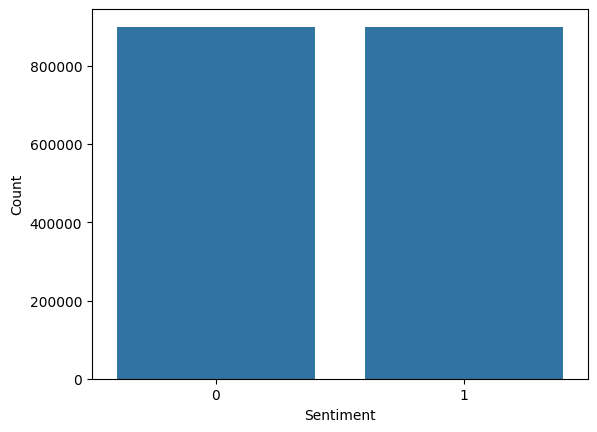

In [6]:
sns.countplot(data=train,x='polarity')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Frequency')

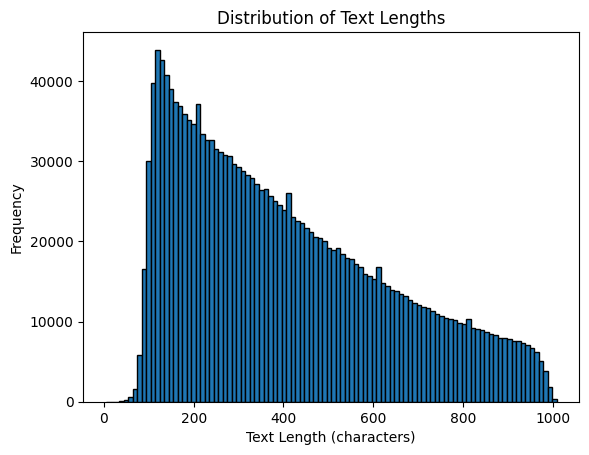

In [7]:
train['length']=train['text'].apply(len)
train['length'].plot(bins=100,kind='hist',edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')

In [8]:
negative= train[train['polarity']==0]
print(negative)

         polarity                                              title  \
0               0                                      What a Waste!   
1               0  2.5 stars- This is a pretty forgettable Priest...   
5               0                                 Painful Experience   
6               0                         Don't buy this crap please   
7               0                                   Better off dead!   
...           ...                                                ...   
1799988         0                                          spiderman   
1799989         0                             Just Can't Watch These   
1799991         0                                     Terrible Movie   
1799994         0               Time has not been good for this book   
1799996         0                                             uhhhhh   

                                                      text  length  
0        I was a huge fan of the first movie. The secon...     290

In [9]:
negative_list=negative['text'].tolist()
negative_sentence="".join(negative_list)
len(negative_list)

900000

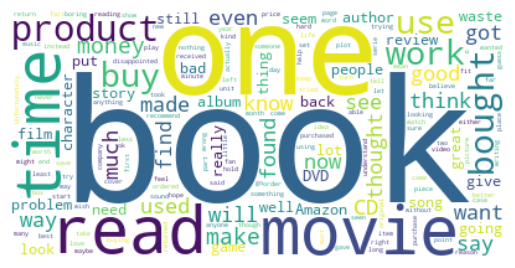

In [10]:
wordcloud = WordCloud(background_color='white').generate(negative_sentence)
plt.imshow(wordcloud, interpolation='bilinear')  
plt.axis('off')  
plt.show()  

In [11]:
positive= train[train['polarity']==1]
print(positive)

         polarity                            title  \
2               1                             Amen   
3               1                          Amazing   
4               1                 Sexy german film   
9               1      The most awesome book ever!   
10              1                            great   
...           ...                              ...   
1799993         1        Works Fine In Windows 7/8   
1799995         1                    Great Headset   
1799997         1  Rolodex Swivel Base Rotary File   
1799998         1                    History Alive   
1799999         1             David Loves New York   

                                                      text  length  
2        Although calling it "essential" might be stret...     405  
3        I use warm water and dissolve the powder. Then...     226  
4        I first saw this film as a kid on late night T...     293  
9        I am not one to buy a lot of books, as long as...     304  
10    

In [12]:
positive_list=positive['text'].tolist()
positive_sentence="".join(positive_list)

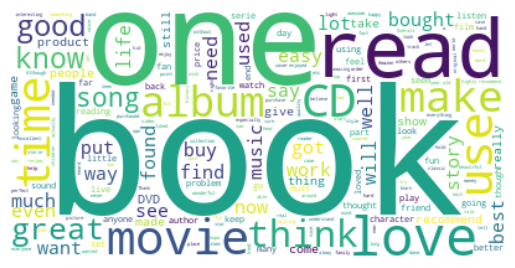

In [13]:

wordcloud = WordCloud(background_color='white').generate(positive_sentence)

plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.show()  

In [14]:
def unigram_analysis(reviews, top_k=10):
    vectorizer = CountVectorizer(stop_words='english')  
    unigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Sum frequencies of each unigram
    unigram_counts = unigram_matrix.sum(axis=0).A1
    unigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame of unigrams and their counts
    unigram_df = pd.DataFrame({'unigram': unigram_features, 'count': unigram_counts})
    unigram_df = unigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return unigram_df

In [15]:
positive_reviews = train[train['polarity'] == 1]['text']
negative_reviews = train[train['polarity'] == 0]['text']
positive_unigrams = unigram_analysis(positive_reviews, top_k=10)
negative_unigrams = unigram_analysis(negative_reviews, top_k=10)

print("Top 10 Positive Unigrams:")
print(positive_unigrams)

print("\nTop 10 Negative Unigrams:")
print(negative_unigrams)

Top 10 Positive Unigrams:
       unigram   count
56660     book  456075
162858   great  298810
217378    like  234450
160241    good  233088
201288    just  191491
300142    read  181451
221914    love  154459
370344    time  147892
300731  really  141213
245894   movie  120368

Top 10 Negative Unigrams:
        unigram   count
54076      book  444190
183512     just  262442
196550     like  260993
147290     good  187036
334675     time  168873
106656      don  167170
220968    movie  149695
270878     read  139403
271418   really  133385
261730  product  126511


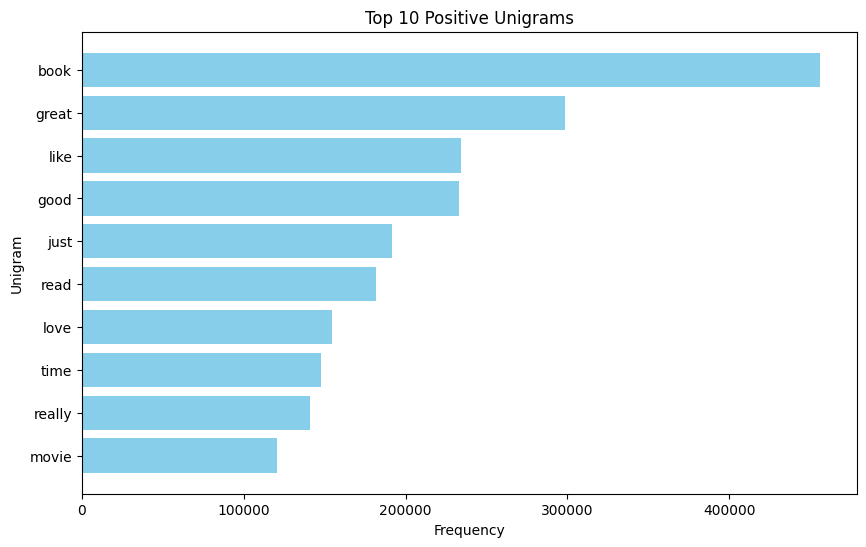

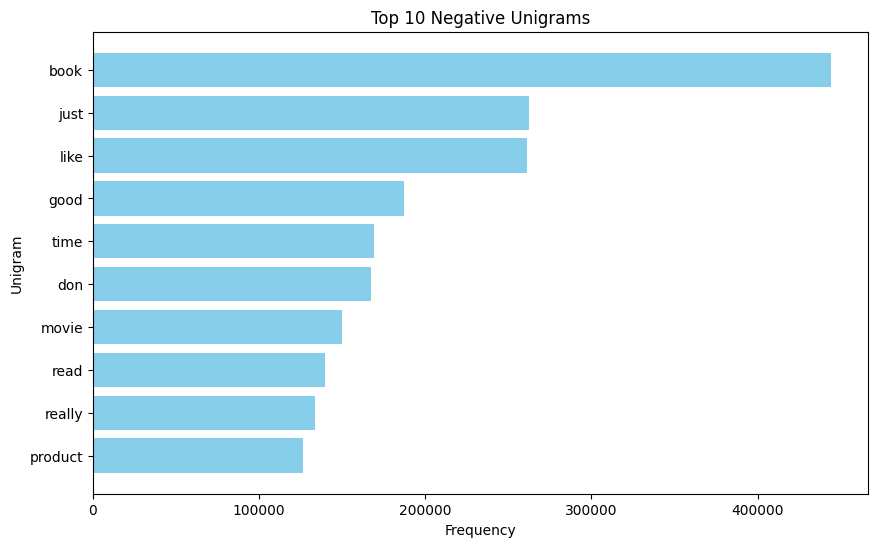

In [16]:
def plot_unigrams(unigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(unigram_df['unigram'], unigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Unigrams
plot_unigrams(positive_unigrams, "Top 10 Positive Unigrams")

# Plot Negative Unigrams
plot_unigrams(negative_unigrams, "Top 10 Negative Unigrams")

In [17]:
train.head()

,polarity,title,text,length
0,0,What a Waste!,I was a huge fan of the first movie. The secon...,290
1,0,2.5 stars- This is a pretty forgettable Priest...,Priest sounds very much like they're trying to...,589
2,1,Amen,"Although calling it ""essential"" might be stret...",405
3,1,Amazing,I use warm water and dissolve the powder. Then...,226
4,1,Sexy german film,I first saw this film as a kid on late night T...,293


In [29]:
train['length'].max()

np.int64(1009)

**DATA PREPROCESSING**


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
tqdm.pandas()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def fast_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [
        lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)
        if word not in stop_words and len(word) > 2
    ]
    return ' '.join(tokens)


train['cleaned_text'] = train['text'].progress_apply(fast_clean)
test['cleaned_text'] = test['text'].progress_apply(fast_clean)

100%|██████████| 399999/399999 [00:29<00:00, 13512.97it/s]


In [30]:
train['cleaned_text']

0          huge fan first movie second came along althoug...
1          priest sound much like theyre trying sound lik...
2          although calling essential might stretching tr...
3          use warm water dissolve powder dump white let ...
4          first saw film kid late night overlying sexual...
                                 ...                        
1799995    second head set love voice reception great dro...
1799996    boy sucker doesnt know die questioning one alo...
1799997    think ordered larger one could really done sma...
1799998    mcculloughs great gift ability present fact da...
1799999    let start saying old school bowie fan first di...
Name: cleaned_text, Length: 1800000, dtype: object

In [19]:

train_label=train.drop(['title','text','cleaned_text'],axis=1)
test_label=test.drop(['title','text','cleaned_text'],axis=1)

In [20]:

MAX_WORD=5000
MAX_LEN=200

combined_train = train['cleaned_text']
combined_test = test['cleaned_text']

tokenizer = Tokenizer(num_words=MAX_WORD)
tokenizer.fit_on_texts(combined_train.astype(str)) 

train_sequences = tokenizer.texts_to_sequences(combined_train.astype(str))
test_sequences = tokenizer.texts_to_sequences(combined_test.astype(str))

train_sequences_matrix = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=MAX_LEN)

In [34]:
test_sequences_matrix.shape, train_sequences_matrix.shape


((399999, 200), (1800000, 200))

In [21]:
from sklearn.model_selection import train_test_split  
x_train, x_val, y_train, y_val = train_test_split(
    train_sequences_matrix, train_label, test_size=0.2, random_state=42)


In [22]:
y_train.drop(['length'], axis=1, inplace=True)
y_val.drop(['length'], axis=1, inplace=True)




In [23]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1440000, 200), (1440000, 1), (360000, 200), (360000, 1))

**MODEL**

**RNN**

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
model= Sequential()
model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=MAX_LEN))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 225s 80ms/step - accuracy: 0.8228 - loss: 0.3866 - val_accuracy: 0.8658 - val_loss: 0.3120
Epoch 2/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 263s 94ms/step - accuracy: 0.8676 - loss: 0.3145 - val_accuracy: 0.8705 - val_loss: 0.3061
Epoch 3/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 269s 95ms/step - accuracy: 0.8723 - loss: 0.3047 - val_accuracy: 0.8721 - val_loss: 0.3042
Epoch 4/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 253s 90ms/step - accuracy: 0.8768 - loss: 0.2960 - val_accuracy: 0.8748 - val_loss: 0.2967
Epoch 5/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 232s 82ms/step - accuracy: 0.8824 - loss: 0.2854 - val_accuracy: 0.8762 - val_loss: 0.2958


In [39]:

texts = test['cleaned_text'].astype(str)  


x_test = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)
pred_probs = model.predict(x_test)
predicted_labels = (pred_probs > 0.5).astype(int).flatten()

test['predicted_label_rnn'] = predicted_labels
test.to_csv('test_with_predictions.csv', index=False)


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step


In [40]:
x_test.shape, x_train.shape


((399999, 200), (1440000, 200))

In [51]:

correct_predictions = (test['predicted_label_rnn'] == test['polarity']).sum()
total_predictions = len(test)
accuracy = correct_predictions / total_predictions
print(f"Accuracy of the RNN model on test data: {accuracy:.2f}")


Accuracy of the RNN model on test data: 0.87


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87    200000
    Positive       0.87      0.88      0.88    199999

    accuracy                           0.87    399999
   macro avg       0.87      0.87      0.87    399999
weighted avg       0.87      0.87      0.87    399999

RNN Model Test Accuracy: 0.87


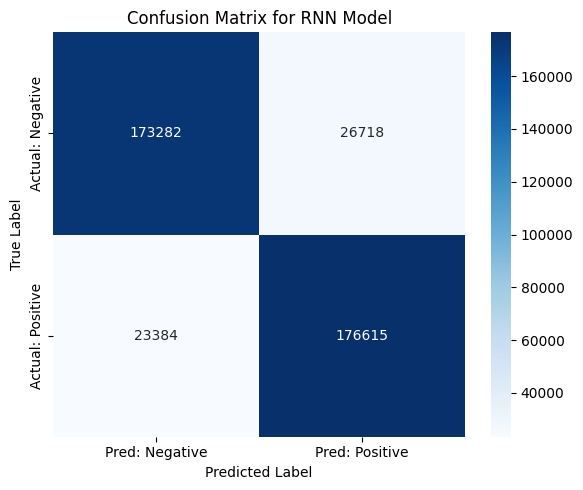

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
if test['polarity'].dtype == object:
    test['polarity'] = test['polarity'].map({'positive': 1, 'negative': 0})


y_true = test['polarity'].astype(int)
y_pred = test['predicted_label_rnn'].astype(int)


cm = confusion_matrix(y_true, y_pred)


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


accuracy = accuracy_score(y_true, y_pred)
print(f"RNN Model Test Accuracy: {accuracy:.2f}")


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Negative', 'Pred: Positive'],
            yticklabels=['Actual: Negative', 'Actual: Positive'])
plt.title("Confusion Matrix for RNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


**LSTM**


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
model = Sequential()
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=200))
lstm_model.add(LSTM(64)) 
lstm_model.add(Dropout(0.5))  
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=512,
    verbose=1
)
loss, accuracy = lstm_model.evaluate(x_val, y_val)
print(f"LSTM Test Accuracy: {accuracy:.4f}")

Epoch 1/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 485s 191ms/step - accuracy: 0.8336 - loss: 0.3680 - val_accuracy: 0.8757 - val_loss: 0.2917
Epoch 2/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 534s 211ms/step - accuracy: 0.8815 - loss: 0.2832 - val_accuracy: 0.8858 - val_loss: 0.2725
Epoch 3/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 514s 203ms/step - accuracy: 0.8905 - loss: 0.2639 - val_accuracy: 0.8907 - val_loss: 0.2624
Epoch 4/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 512s 202ms/step - accuracy: 0.8977 - loss: 0.2490 - val_accuracy: 0.8931 - val_loss: 0.2598
Epoch 5/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 522s 206ms/step - accuracy: 0.9029 - loss: 0.2381 - val_accuracy: 0.8940 - val_loss: 0.2575
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.8928 - loss: 0.2598
LSTM Test Accuracy: 0.8934


In [60]:
texts = test['cleaned_text'].astype(str)  


x_test = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)
pred_probs = lstm_model.predict(x_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
test['predicted_label_lstm'] = pred_labels
test.to_csv('test_predictions_lstm.csv', index=False)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 93s 7ms/step


In [61]:
correct_predictions = (test['predicted_label_lstm'] == test['polarity']).sum()
total_predictions = len(test)
accuracy = correct_predictions / total_predictions
print(f"Accuracy of the LSTM model on test data: {accuracy:.2f}")

Accuracy of the LSTM model on test data: 0.89


📊 Classification Report (LSTM):
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89    200000
    Positive       0.89      0.90      0.89    199999

    accuracy                           0.89    399999
   macro avg       0.89      0.89      0.89    399999
weighted avg       0.89      0.89      0.89    399999

✅ LSTM Model Accuracy on Test Set: 0.89


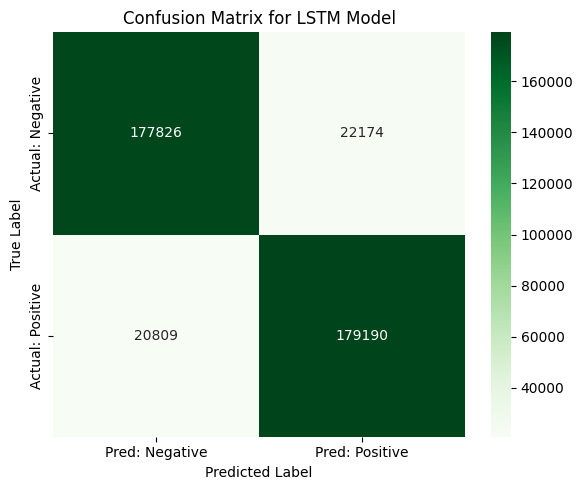

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


if test['polarity'].dtype == object:
    test['polarity'] = test['polarity'].map({'negative': 0, 'positive': 1})


y_true = test['polarity'].astype(int)
y_pred_lstm = test['predicted_label_lstm'].astype(int)


cm_lstm = confusion_matrix(y_true, y_pred_lstm)


print("Classification Report (LSTM):")
print(classification_report(y_true, y_pred_lstm, target_names=["Negative", "Positive"]))


accuracy_lstm = accuracy_score(y_true, y_pred_lstm)
print(f"LSTM Model Accuracy on Test Set: {accuracy_lstm:.2f}")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred: Negative', 'Pred: Positive'],
            yticklabels=['Actual: Negative', 'Actual: Positive'])
plt.title("Confusion Matrix for LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout


gru_model = Sequential()
gru_model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=200))
gru_model.add(GRU(64))  
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gru_history = gru_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    verbose=1
)


loss, accuracy = gru_model.evaluate(x_val,y_val)
print(f"GRU Test Accuracy: {accuracy:.4f}")


Epoch 1/5
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 511s 50ms/step - accuracy: 0.8481 - loss: 0.3459 - val_accuracy: 0.8838 - val_loss: 0.2749
Epoch 2/5
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 515s 51ms/step - accuracy: 0.8882 - loss: 0.2688 - val_accuracy: 0.8905 - val_loss: 0.2632
Epoch 3/5
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 910s 90ms/step - accuracy: 0.8973 - loss: 0.2496 - val_accuracy: 0.8933 - val_loss: 0.2570
Epoch 4/5
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 654s 65ms/step - accuracy: 0.9033 - loss: 0.2370 - val_accuracy: 0.8941 - val_loss: 0.2574
Epoch 5/5
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 664s 66ms/step - accuracy: 0.9090 - loss: 0.2246 - val_accuracy: 0.8945 - val_loss: 0.2552
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - accuracy: 0.8944 - loss: 0.2556
GRU Test Accuracy: 0.8948


In [ ]:
texts = test['cleaned_text'].astype(str)  


x_test = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)
pred_probs = gru_model.predict(x_test)


predicted_labels = (pred_probs > 0.5).astype(int).flatten()


test['predicted_label_gru'] = predicted_labels


if 'polarity' in test.columns:

    if test['polarity'].dtype == object:
        test['polarity'] = test['polarity'].map({'positive': 1, 'negative': 0})

    accuracy = (test['predicted_label_gru'] == test['polarity']).mean()
    print(f"GRU Model Accuracy on Test Set: {accuracy:.2f}")
else:
    print("No 'polarity' column found in test data — predictions saved only.")


test.to_csv("test_with_gru_predictions.csv", index=False)


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step
GRU Model Accuracy on Test Set: 0.89


📊 Classification Report (GRU):
              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89    200000
    Positive       0.90      0.89      0.89    199999

    accuracy                           0.89    399999
   macro avg       0.89      0.89      0.89    399999
weighted avg       0.89      0.89      0.89    399999

✅ GRU Model Accuracy on Test Set: 0.89


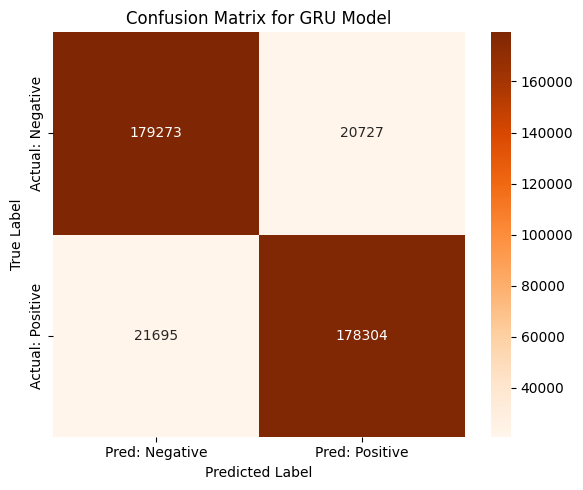

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


if test['polarity'].dtype == object:
    test['polarity'] = test['polarity'].map({'negative': 0, 'positive': 1})


y_true = test['polarity'].astype(int)
y_pred_gru = test['predicted_label_gru'].astype(int)


cm_gru = confusion_matrix(y_true, y_pred_gru)


print("Classification Report (GRU):")
print(classification_report(y_true, y_pred_gru, target_names=["Negative", "Positive"]))


accuracy_gru = accuracy_score(y_true, y_pred_gru)
print(f"GRU Model Accuracy on Test Set: {accuracy_gru:.2f}")


plt.figure(figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pred: Negative', 'Pred: Positive'],
            yticklabels=['Actual: Negative', 'Actual: Positive'])
plt.title("Confusion Matrix for GRU Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
